<a href="https://colab.research.google.com/github/san-11/music-genre-classifier/blob/main/musicgenre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The training data that we use in this project uses .wav files. So, we will install a package that converts an MP3 file into a .wav format. Note that, most of the downloads these days are in .mp3 format. To facilitate this conversion, install the pydub package using following command.

In [ ]:
!pip install python_speech_features
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=4d7b0cfa8b6de5423ce187dbca9c0527da59fba00e849bc244904e8608bae95a
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


 Import all required libraries in the project:

In [ ]:
import numpy as np
import os
import pickle
import random
import pandas as pd
import sklearn
import scipy.io.wavfile as wav
from os import path
from pydub import AudioSegment
from python_speech_features import mfcc
from sklearn.metrics import classification_report
from collections import defaultdict

Unzip the downloaded files:

In [ ]:
!wget https://github.com/abcom-mltutorials/music-genre/archive/master.zip

!unzip "/content/master.zip"

--2022-10-20 16:38:00--  https://github.com/abcom-mltutorials/music-genre/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/abcom-mltutorials/music-genre/zip/refs/heads/master [following]
--2022-10-20 16:38:00--  https://codeload.github.com/abcom-mltutorials/music-genre/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [          <=>       ]   1.04G  16.8MB/s    in 65s     

2022-10-20 16:39:05 (16.3 MB/s) - ‘master.zip’ saved [1112708013]

Archive:  /content/master.zip
03fd633a595570c9edc4c0417aad1ad90bf492f6
   creating: music-genre-master/
  inflatin

We will create a Python list of all the downloaded files for processing them in a single loop.The output shows you that there are totally 900 files (9 categories * 100 files in each.)

In [ ]:
directory = "/content/music-genre-master/Dataset"
filelist=[]
for path, subdirs, files in os.walk(directory):
   for file in files:
       if (file.endswith('.wav') or file.endswith('.WAV')):
           filelist.append(os.path.join(path, file))
number_of_files=len(filelist)
print(number_of_files)

900


We use the MFCC(Mel-frequency cepstral coefficients) library from python_speech_features module for extracting music features. This library extracts 13 features from the audio file. We write a utility function to extract the features:

In [ ]:
def feature_extraction(file):
 features=[]
 (sampleRate,data) = wav.read(file)
 mfcc_feature = mfcc(data,sampleRate,
                           winlen=0.020,
                           appendEnergy = False)
 meanMatrix = mfcc_feature.mean(0)
 for x in meanMatrix:
   features.append(x)
 return features

We create a loop to extract the features of each file in our database along with the class label and create a Python list for feeding it to our ML model.

In [ ]:
datasetDirectory = "/content/music-genre-master/Dataset/"

featureSet=[]
i=0
for folder in os.listdir(datasetDirectory):
   i+=1
   if i > 9: # the number of genres is 9
       break
   for files in os.listdir(datasetDirectory+folder):
     x=datasetDirectory+folder+"/"+files
     features=feature_extraction(x)
     j=0
     for x in features:
       featureSet.append(x)
       j=j+1
       if(j%13==0):
         featureSet.append(i)

To examine the contents of the created list, try this print statement.Thus, the values from 14 through 27 will show the features of the second file in our dataset. The last value in the print output is 1, which shows that the genre of this second file is of type 1, which is “Blues.”

In [ ]:
for i in range(14,28):
 print (featureSet[i])

66.0159089291739
7.318642039176122
-3.630719195622741
7.477667758210491
-3.8325015082537073
7.394798301651919
-15.616784414375585
5.440683454229917
-15.426153006509821
3.568401616951543
-5.056542265475403
0.29967490715456496
-6.634330612255568
1


Convert the features list into a dataframe for further processing. We name the thirteen columns for features and a target column for the target value as follows.

In [ ]:
df = pd.DataFrame(columns=['m1','m2','m3','m4','m5','m6','m7',
                          'm8','m9','m10','m11','m12','m13','target'])

We create a loop for constructing the dataframe from featureSet as follows:

In [ ]:
i=1
n=[]
for j in featureSet:
 n.append(j)
 #13 features + 1 taget
 if(i%14==0):
   df = df.append({'m1':n[0],'m2':n[1],'m3':n[2],'m4':n[3],'m5':n[4],
                   'm6':n[5],'m7':n[6],'m8':n[7],'m9':n[8],'m10':n[9],
                   'm11':n[10],'m12':n[11],'m13':n[12],'target':n[13]},
                  ignore_index=True)
   n=[]
 i=i+1

We separate out the features and labels using the following code.You will see that the shape of x1 is (900,13) showing 900 rows one for each file and 13 columns that give the features for each individual .wav file. The target shape is obviously (900,1), where the column shows the class of genre.

In [ ]:
x1=df[['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','m13']]
x1.shape

Y = df[['target']]
Y.shape

(900, 1)

Split the dataset into training and testing using sklearn library

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x1, Y,
                                                   test_size=0.2,
                                                   random_state=42)

Training the logistic regression model using the earlier generated dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Use the trained model on the test dataset.

In [ ]:
predicted_value = clf.predict(X_test)
predicted_value

array([5., 9., 3., 9., 1., 9., 3., 2., 1., 1., 2., 9., 9., 2., 8., 7., 2.,
       5., 5., 1., 7., 8., 6., 4., 6., 5., 1., 9., 5., 7., 3., 3., 3., 9.,
       4., 7., 1., 7., 7., 3., 1., 7., 4., 1., 6., 1., 3., 9., 5., 9., 7.,
       8., 3., 3., 3., 4., 9., 9., 6., 6., 9., 4., 8., 7., 3., 2., 7., 8.,
       4., 5., 6., 6., 9., 1., 2., 9., 5., 7., 1., 1., 6., 2., 7., 1., 9.,
       9., 7., 3., 3., 6., 8., 3., 9., 9., 8., 4., 9., 2., 1., 8., 8., 5.,
       1., 6., 9., 3., 8., 3., 9., 5., 9., 2., 6., 5., 9., 7., 9., 9., 8.,
       9., 5., 6., 3., 7., 3., 7., 3., 8., 8., 2., 6., 9., 4., 2., 3., 3.,
       6., 9., 1., 3., 3., 9., 6., 8., 8., 3., 9., 2., 6., 1., 1., 7., 5.,
       4., 5., 2., 1., 6., 9., 7., 1., 7., 6., 4., 8., 5., 1., 9., 9., 5.,
       9., 3., 7., 5., 6., 9., 9., 3., 9., 7.])

As you can see, we classify each file in the test dataset in one category ranging from 1 to 9. You may visualize the performance by plotting the confusion matrix using the following code:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


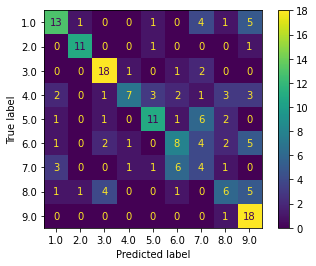

In [ ]:
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)

Another way to evaluate the performance is by printing the various metrics:

In [ ]:
print(classification_report(y_test, predicted_value))

              precision    recall  f1-score   support

         1.0       0.62      0.52      0.57        25
         2.0       0.85      0.85      0.85        13
         3.0       0.69      0.82      0.75        22
         4.0       0.70      0.32      0.44        22
         5.0       0.65      0.50      0.56        22
         6.0       0.42      0.35      0.38        23
         7.0       0.19      0.25      0.22        16
         8.0       0.38      0.33      0.35        18
         9.0       0.49      0.95      0.64        19

    accuracy                           0.53       180
   macro avg       0.55      0.54      0.53       180
weighted avg       0.56      0.53      0.52       180



In [ ]:
audio_file="/content/music-genre-master/new_audio_file.wav"
audio_feature=feature_extraction(audio_file)

The code is like what you did for your training and testing data above. It stores the extracted features in a list. We do a prediction on this list using our trained model clf.

In [ ]:
from collections import defaultdict
results=defaultdict(int)
i=1
for folder in os.listdir("/content/music-genre-master/Dataset/"):
    results[i]=folder
    i+=1
pred_audio=clf.predict([audio_feature])
results[int(pred_audio)]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


'country'

Just copy any desired mp3 file to your content folder. We need to convert this file into a .wav format. Declare the two variables:

In [ ]:
src="/content/sample1.mp3"
dst = "test.wav"

Convert the file using following code:

In [ ]:
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

<_io.BufferedRandom name='test.wav'>

Extract the features using our earlier defined function:

In [ ]:
audio_file="/content/test.wav"
audio_feature=feature_extraction(audio_file)


Predict the genre using the following code.

In [ ]:
pred_audio=clf.predict([audio_feature])
results[int(pred_audio)-2]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


'blues'